# RL Traveling Salesman

In this notebook, we implement a reinforcement learning approach to the traveling salesman problem. It is based on Q-learning and structure2vec graph embeddings.

References: <br>
https://www.youtube.com/watch?v=i6Mi2_QM3rA <br>
https://arxiv.org/pdf/1611.09940.pdf <br>
http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/#disqus_thread <br>
https://towardsdatascience.com/reinforcement-learning-for-combinatorial-optimization-d1402e396e91 <br><br>
The main idea has been borrowed from the following article : <br>https://medium.com/unit8-machine-learning-publication/routing-traveling-salesmen-on-random-graphs-using-reinforcement-learning-in-pytorch-7378e4814980 <br>

In [1]:
import numpy as np
import random
import math
from collections import namedtuple
import os
import time

import tensorflow as tf
import tensorflow.keras.layers as kl
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.activations import relu

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

from scipy.signal import medfilt

""" Note: the code is not optimized for GPU
"""
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device

' Note: the code is not optimized for GPU\n'

## Create Graph Instances
Below we implement a small method to generate random graph instances.

In [2]:
def get_graph_mat(n=10, size=1):
    """ Throws n nodes uniformly at random on a square, and build a (fully connected) graph.
        Returns the (N, 2) coordinates matrix, and the (N, N) matrix containing pairwise euclidean distances.
    """
    coords = size * np.random.uniform(size=(n,2))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat

def plot_graph(coords, mat):
    """ Utility function to plot the fully connected graph
    """
    n = len(coords)
    
    plt.scatter(coords[:,0], coords[:,1], s=[50 for _ in range(n)])
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([coords[i,0], coords[j,0]], [coords[i,1], coords[j,1]], 'b', alpha=0.7)

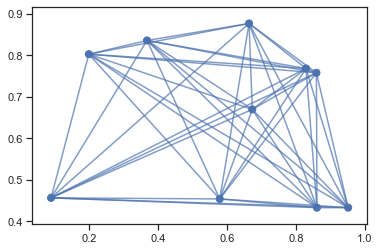

In [3]:
coords, W_np = get_graph_mat(n=10)
plot_graph(coords, W_np)

## Define the state
We now define the state tuple, containing a graph (given by a weights matrix `W`), the noode coordinates `coords` and the partial solution (list of visited nodes).
We also define the function `state2tens`, which translates such tuples into tensors (partially loosing the sequence order information).

In [30]:
State = namedtuple('State', ('W', 'coords', 'partial_solution'))
  
def state2tens(state):
    """ Creates a Pytorch tensor representing the history of visited nodes, from a (single) state tuple.
        
        Returns a (Nx5) tensor, where for each node we store whether this node is in the sequence,
        whether it is first or last, and its (x,y) coordinates.
    """
    solution = set(state.partial_solution)
    sol_last_node = state.partial_solution[-1] if len(state.partial_solution) > 0 else -1
    sol_first_node = state.partial_solution[0] if len(state.partial_solution) > 0 else -1
    coords = state.coords
    nr_nodes = coords.shape[0]

    xv = [[(1 if i in solution else 0),
           (1 if i == sol_first_node else 0),
           (1 if i == sol_last_node else 0),
           coords[i,0],
           coords[i,1]
          ] for i in range(nr_nodes)]
    
    return tf.convert_to_tensor(xv, dtype=tf.float32).numpy()

In [31]:
# s = State(W_np, coords, [0,1])

# state2tens(s)

## The Q-Function
Below, we write the neural network that will parameterize the function Q(s, a).

In [32]:
@tf.function
def reduce_sum(x, keepdims):
    return tf.math.reduce_sum(x, axis=1, keepdims=keepdims)

In [78]:
class QNet(tf.keras.Model):
    """ The neural net that will parameterize the function Q(s, a)
    
        The input is the state (containing the graph and visited nodes),
        and the output is a vector of size N containing Q(s, a) for each of the N actions a.
    """    
    
    def __init__(self, emb_dim, T=4):
        """ emb_dim: embedding dimension p
            T: number of iterations for the graph embedding
        """
        super(QNet, self).__init__()
        self.emb_dim = emb_dim
        self.T = T
        
        # We use 5 dimensions for representing the nodes' states:
        # * A binary variable indicating whether the node has been visited
        # * A binary variable indicating whether the node is the first of the visited sequence
        # * A binary variable indicating whether the node is the last of the visited sequence
        # * The (x, y) coordinates of the node.
        self.node_dim = 5
        
        # We can have an extra layer after theta_1 (for the sake of example to make the network deeper)
        nr_extra_layers_1 = 1
        
        # Build the learnable affine maps:
        self.theta1 = tf.keras.layers.Dense(self.emb_dim, use_bias=True, kernel_initializer='glorot_uniform')
        self.theta2 = tf.keras.layers.Dense(self.emb_dim, use_bias=True, kernel_initializer='glorot_uniform')
        self.theta3 = tf.keras.layers.Dense(self.emb_dim, use_bias=True, kernel_initializer='glorot_uniform')
        self.theta4 = tf.keras.layers.Dense(self.emb_dim, use_bias=True, kernel_initializer='glorot_uniform')
        self.theta5 = tf.keras.layers.Dense(1, use_bias=True, kernel_initializer='glorot_uniform')
        self.theta6 = tf.keras.layers.Dense(self.emb_dim, use_bias=True, kernel_initializer='glorot_uniform')
        self.theta7 = tf.keras.layers.Dense(self.emb_dim, use_bias=True, kernel_initializer='glorot_uniform')
                
        self.theta1_extras = [tf.keras.layers.Dense(self.emb_dim, use_bias=True) for _ in range(nr_extra_layers_1)]
    
    def call(self, xv, Ws):
        # xv: The node features (batch_size, num_nodes, node_dim)
        # Ws: The graphs (batch_size, num_nodes, num_nodes)
        
        num_nodes = xv.shape[1]
        batch_size = xv.shape[0]
        
        # pre-compute 1-0 connection matrices masks (batch_size, num_nodes, num_nodes)
        conn_matrices = tf.where(Ws > 0, tf.ones_like(Ws), tf.zeros_like(Ws))
        
        # Graph embedding
        # Note: we first compute s1 and s3 once, as they are not dependent on mu
        mu = tf.zeros(shape=[batch_size, num_nodes, self.emb_dim])
        s1 = self.theta1(xv)  # (batch_size, num_nodes, emb_dim)
        for layer in self.theta1_extras:
            s1 = layer(relu(s1))  # we apply the extra layer
        
        
        
        s3_1 = relu(self.theta4(tf.expand_dims(Ws, 3)))  # (batch_size, nr_nodes, nr_nodes, emb_dim) - each "weigth" is a p-dim vector        
        s3_2 = reduce_sum(s3_1, keepdims=False)  # (batch_size, nr_nodes, emb_dim) - the embedding for each node
        s3 = self.theta3(s3_2)  # (batch_size, nr_nodes, emb_dim)
        
        for t in range(self.T):
            s2 = self.theta2(tf.linalg.matmul(conn_matrices, mu))    
            mu = relu(s1 + s2 + s3)
            
        """ prediction
        """
        # we repeat the global state (summed over nodes) for each node, 
        # in order to concatenate it to local states later
        temp = tf.constant([1, num_nodes, 1])
        global_state = self.theta6(tf.tile(reduce_sum(mu, keepdims=True), temp))
        
        local_action = self.theta7(mu)  # (batch_dim, nr_nodes, emb_dim)
            
        out = relu(tf.concat([global_state, local_action], axis=2))
        return tf.squeeze(self.theta5(out), axis=2)

In [79]:
""" See what the model returns
"""
model = QNet(3, T=1)
coords, W_np = get_graph_mat(n=10)
W = tf.convert_to_tensor(W_np, dtype=tf.float32)
xv = tf.random.uniform((1, W.shape[0], 5)) # random node state
Ws = tf.expand_dims(W, 0)

y = model(xv, Ws)
print('model output: {}'.format(y))

' See what the model returns\n'

model output: [[-3.6373372 -3.3378243 -3.771854  -2.7031739 -2.8244755 -3.0825644
  -2.9528332 -3.3488536 -3.5034506 -3.3013852]]


### A wrapper around the neural net
Below, we define the class `QFunction`, which will act as a wrapper around the neural net `QNet`, and can manipulate TSP (partial) solutions and translate them to tensors.

In [80]:
class QFunction():
    def __init__(self, model, optimizer, lr_scheduler):
        self.model = model  # The actual QNet
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = mean_squared_error
    
    def predict(self, state_tsr, W):
        # batch of 1 - only called at inference time
        estimated_rewards = self.model(tf.expand_dims(state_tsr, 0), tf.expand_dims(W, 0), training=False)
        return estimated_rewards[0]
                
    def get_best_action(self, state_tsr, state):
        """ Computes the best (greedy) action to take from a given state
            Returns a tuple containing the ID of the next node and the corresponding estimated reward
        """
        W = state.W
        estimated_rewards = self.predict(state_tsr, W)  # size (nr_nodes,)
        sorted_reward_idx = tf.argsort(estimated_rewards, direction='DESCENDING')
        
        solution = state.partial_solution
        
        already_in = set(solution)
        for idx in sorted_reward_idx.numpy():
            if (len(solution) == 0 or W[solution[-1], idx] > 0) and idx not in already_in:
                return idx, estimated_rewards[idx].numpy()
      
    def batch_update(self, states_tsrs, Ws, actions, targets):
        """ Take a gradient step using the loss computed on a batch of (states, Ws, actions, targets)
        
            states_tsrs: list of (single) state tensors
            Ws: list of W tensors
            actions: list of actions taken
            targets: list of targets (resulting estimated rewards after taking the actions)
        """        
        Ws_tsr = tf.stack(Ws)
        xv = tf.stack(states_tsrs)
        
        # the rewards estimated by Q for the given actions
        estimated_rewards = self.model(xv, Ws_tsr)
        
        idx = [[i, actions[i]] for i in range(len(actions))]
        estimated_rewards = tf.gather_nd(estimated_rewards, idx)
        
        with tf.GradientTape() as tape:
        
            loss = self.loss_fn(estimated_rewards, tf.convert_to_tensor(targets))
            # print (loss)
            loss_val = loss.numpy()
        
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        return loss_val

## Define experiences & memory
We'll now a tuple representing an experience, and the memory that contains such experiences.
An experience is composed of a (state, action) tuple, and the corresponding "next state" and reward. The "next state" can be N step after the "state" in the case of N-step Q-learning. In experiences, we save states both in their tuple and tensor representations, in order to avoid computing these somewhat expensive translations after the experience has been stored.

The `Memory` class implements a memory of limited size.

In [81]:
# Note: we store state tensors in experience to compute these tensors only once later on
Experience = namedtuple('Experience', ('state', 'state_tsr', 'action', 'reward', 'next_state', 'next_state_tsr'))

class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0
        
    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        self.nr_inserts += 1
        
    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return min(self.nr_inserts, self.capacity)

## Other useful things
Below, we'll write a few more helper functions for computing solution length, deciding if a state is final and getting a next node at random from the graph.

In [82]:
def total_distance(solution, W):
    if len(solution) < 2:
        return 0  # there is no travel
    
    total_dist = 0
    for i in range(len(solution) - 1):
        total_dist += W[solution[i], solution[i+1]].numpy()
        
    # if this solution is "complete", go back to initial point
    if len(solution) == W.shape[0]:
        total_dist += W[solution[-1], solution[0]].numpy()

    return total_dist
        
def is_state_final(state):
    return len(set(state.partial_solution)) == state.W.shape[0]

def get_non_zero_indices(A):
    
    zero = tf.constant(0, dtype=tf.float32)
    where = tf.not_equal(A, zero)
    
    indices = tf.where(where)
    
    return indices

def get_next_neighbor_random(state):
    solution, W = state.partial_solution, state.W
    
    if len(solution) == 0:
        return random.choice(range(W.shape[0]))
    already_in = set(solution)
    candidates = list(filter(lambda n: n.numpy()[0] not in already_in, get_non_zero_indices(W[solution[-1]])))
    if len(candidates) == 0:
        return None
    return random.choice(candidates).numpy()[0]

In [83]:
# for i in get_non_zero_indices(W[0]):
#     print (i.numpy()[0])

# W = tf.constant([1,0,1,0], dtype=tf.float32)
# for i in get_non_zero_indices(W):
#     print (i.numpy()[0])

## Training Code
### Hyper-parameters

In [84]:
SEED = 1  # A seed for the random number generator

# Graph
NR_NODES = 10  # Number of nodes N
EMBEDDING_DIMENSIONS = 5  # Embedding dimension D
EMBEDDING_ITERATIONS_T = 1  # Number of embedding iterations T

# Learning
NR_EPISODES = 250
MEMORY_CAPACITY = 10000
N_STEP_QL = 2  # Number of steps (n) in n-step Q-learning to wait before computing target reward estimate
BATCH_SIZE = 16

GAMMA = 0.9
INIT_LR = 5e-3
LR_DECAY_RATE = 1. - 2e-5  # learning rate decay

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 6e-4  # epsilon decay

FOLDER_NAME = './models'  # where to checkpoint the best models

### Model Initialization & checkpointing
We will save our best models over the course of training - here we just define two functions for loading and checkpointing models

In [85]:
def init_model(fname=None):
    """ Create a new model. If fname is defined, load the model from the specified file.
    """
    Q_net = QNet(EMBEDDING_DIMENSIONS, T=EMBEDDING_ITERATIONS_T)
    
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    INIT_LR,
    decay_rate=LR_DECAY_RATE, decay_steps=100000)
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
    
    
    Q_func = QFunction(Q_net, optimizer, lr_scheduler)
    return Q_func, Q_net, optimizer, lr_scheduler


### Training Loop

In [87]:
# seed everything for reproducible results first:
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

for episode in range(NR_EPISODES):
    # sample a new random graph
    coords, W_np = get_graph_mat(n=NR_NODES)
    W = tf.convert_to_tensor(W_np, dtype=tf.float32)
    
    # current partial solution - a list of node index
    solution = [random.randint(0, NR_NODES-1)]
    
    # current state (tuple and tensor)
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)
    
    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []
    
    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)
    
    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  # time step of this episode
        
        if epsilon >= random.random():
            # explore
            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))
        
        next_solution = solution + [next_node]
        
        # reward observed for taking this step        
        reward = -(total_distance(next_solution, W) - total_distance(solution, W))
        
        next_state = State(partial_solution=next_solution, W=W, coords=coords)
        next_state_tsr = state2tens(next_state)
        
        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)
        
        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))
            
        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n], 
                                           action=actions[-n], 
                                           reward=sum(rewards[-n:]), 
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))
        
        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution
        
        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 500:
            experiences = memory.sample_batch(BATCH_SIZE)
            
            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []
            
            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr, 
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)
                
            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)
            
#             """ Save model when we reach a new low average path length
#             """
            med_length = np.median(path_lengths[-100:])
#             if med_length < current_min_med_length:
#                 current_min_med_length = med_length
#                 checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)
                
    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 50 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f ' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon))
        found_solutions[episode] = (tf.identity(W), coords.copy(), [n for n in solution])

Ep 0. Loss = -1.000 / median length = 3.487 / last = 3.4873 / epsilon = 1.0000 
Ep 50 | current sol: [8, 5] / next est reward: -2.2378780841827393
Ep 50 | current sol: [8, 5, 6, 4] / next est reward: -2.2621707916259766
Ep 50. Loss = -1.000 / median length = 5.000 / last = 5.5045 / epsilon = 0.9704 


ValueError: No gradients provided for any variable: ['dense_108/kernel:0', 'dense_108/bias:0', 'dense_109/kernel:0', 'dense_109/bias:0', 'dense_110/kernel:0', 'dense_110/bias:0', 'dense_111/kernel:0', 'dense_111/bias:0', 'dense_112/kernel:0', 'dense_112/bias:0', 'dense_113/kernel:0', 'dense_113/bias:0', 'dense_114/kernel:0', 'dense_114/bias:0', 'dense_115/kernel:0', 'dense_115/bias:0'].

## Re-run Best Model and Look at Paths

In [88]:
""" Get file with smallest distance
"""
all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith('.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))

""" Load checkpoint
"""
Q_func, Q_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, shortest_fname))

""" A function to plot solutions
"""
def plot_solution(coords, mat, solution):
    plt.scatter(coords[:,0], coords[:,1])
    n = len(coords)
    
    for idx in range(n-1):
        i, next_i = solution[idx], solution[idx+1]
        plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    
    i, next_i = solution[-1], solution[0]
    plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    plt.plot(coords[solution[0], 0], coords[solution[0], 1], 'x', markersize=10)


    
""" Generate example solutions
"""
NR_NODES = 10
for sample in range(10):
    coords, W_np = get_graph_mat(n=NR_NODES)
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    
    solution = [random.randint(0, NR_NODES-1)]
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)
    
    while not is_state_final(current_state):
        next_node, est_reward = Q_func.get_best_action(current_state_tsr, 
                                                       current_state)
        
        
        solution = solution + [next_node]
        current_state = State(partial_solution=solution, W=W, coords=coords)
        current_state_tsr = state2tens(current_state)
        
    plt.figure()
    plot_solution(coords, W, solution)
    plt.title('model / len = {}'.format(total_distance(solution, W)))
    
    # for comparison, plot a random solution
    plt.figure()
    random_solution = list(range(NR_NODES))
    plot_solution(coords, W, random_solution)
    plt.title('random / len = {}'.format(total_distance(random_solution, W)))